# Seattle Public School Buses

Daily late buses to and from school are scraped from the website four times per day (2 x for to school, 2 x for from school). This captures initial estimates of late buses, and any corrections tot he late time. This data is added to a database. The current database is incomplete due than a less than robust web scraper. The web scraper has been improved with Regular Expressions and I am to implement data collection with a web server so that we have a complete data set.

The functions below focus on two areas:
* (1) Formatting for the map visualization
* (2) Selecting and cleaning the portion of the database that we are interested in visualizing.

Using these function, a map is generated showing the schools with late buses. The size of the circle marker corresponds to the length of time the buses are late at the particular school. The color of the marker indicates the type of school (elementary, high school, middle school, k-8, other).



In [1]:
# import libraries
import datetime
import pandas as pd
import numpy as np
from datascience import *
import random
import ast

%matplotlib inline
import matplotlib.pyplot as plt

from arcgis.gis import GIS

now = datetime.datetime.now()

# import data

# read in schools df
school_df = pd.read_pickle('geocoding_schools/current_school_list.pk1')
# read in late bus df
late_bus_df = pd.read_pickle('scraping_bus_data/bus_data.pk1')

# read in late bus database using datascience package
late_bus_df_datascience = Table.read_table('scraping_bus_data/bus_data.csv')

print("First 10 rows of database:")
late_bus_df[0:10]



First 10 rows of database:


,Month,Day,Year,Bus Number,School,To/From,Time,Unit,Data Taken Month,Data Taken Day,Data Taken Year,Data Taken Hour,Data Taken Minute
0,December,21,2018,3,Adams,from,20,minutes,1,1,2019,20,51
1,December,21,2018,120,Loyal Heights,from,20,minutes,1,1,2019,20,51
2,December,21,2018,630,Queen Anne,from,20,minutes,1,1,2019,20,51
3,December,21,2018,148,Northgate,from,10,minutes,1,1,2019,20,51
4,December,21,2018,799,Gatzert,from,120,minutes,1,1,2019,20,51
5,December,21,2018,462,Washington,from,60,minutes,1,1,2019,20,51
6,December,21,2018,792,Kimball,from,120,minutes,1,1,2019,20,51
7,December,21,2018,402,Cleveland,from,60,minutes,1,1,2019,20,51
8,December,21,2018,624,Fairmount Park,from,120,minutes,1,1,2019,20,51
9,December,21,2018,464,Washington,from,60,minutes,1,1,2019,20,51


## Visualization / Mapping Functions

In [2]:
# color coding function
def color_code_fn(school_type):
    """
    input: school type
    output: color of circle marker
    """
    if school_type == "elementary school": #pink
        color_code = [255,0,125,255]
    elif school_type == "middle school": #red
        color_code = [255,0,0,255]  
    elif school_type == "high school":#purple
        
        color_code = [255,125,255,255] 
    elif school_type == 'k-8': #blue
        color_code = [0,0,255,255] 
    else: #green
        color_code = [0,255,0,255] 
        
    return color_code

# circle diameter function
def circle_diameter_fn(max_diameter, amount, array_of_amounts):
    """
    input: maximum diamter and array of late times of all schools included in visualization
    ouput: scaled diameter of circle markerfor each school
    """
    the_max = max(array_of_amounts)
    
    d = max_diameter*(amount +(the_max-amount)*0.35)/(the_max)
    return d

def map_all_schools_fn(school):
    """
    input: school dictionary (including location (geocode), address, school name, school type))
    output: input for map.draw() method -- including geocode, pop_up description, and marker format
    """
    the_geocode = ast.literal_eval(school['geocode'])
    circle_location = the_geocode['location']
    pop_up_description = {"title" : school['School'], "content" : the_geocode['address']}
    circle_format = {"type": "esriSMS","style": "esriSMSCircle","color": [0,0,0,125],"size": 4,
                         "angle": 0,"xoffset": 0,"yoffset": 0,
                         "outline": {"color": [0,0,0,155],"width": 0}}
    return [circle_location, pop_up_description, circle_format]

def map_late_schools_fn(school, d, color_code, visualize):
    """
    input: (1) school dictionary (including location (geocode), address, school name, school type))
            (2) marker diameter
            (3) marker color code
    output: input for map.draw() method -- including geocode, pop_up description, and marker format
    """
    
    the_geocode = ast.literal_eval(school['geocode'])
    circle_location = the_geocode['location']
    pop_up_description = {"title" : school['School'], "content" : "Late: "+str(school[visualize])+" minutes"}
    circle_format = {"type": "esriSMS","style": "esriSMSCircle","color": color_code,
                     "size": d,"angle": 0,"xoffset": 0,"yoffset": 0,
                     "outline": {"color": [0,0,0,155],"width": 0}}
    return [circle_location, pop_up_description, circle_format]

## Functions that select the rows to create late bus DataFrame of interest.

In [3]:
# get df for the buses that are late today
def today_late_buses_fn(late_bus_df, to_from):
    """
    input: entire late bus data frame, 
            to_from = 'to' or 'from'
    output: buses that were late **to** school **today** dataframe 
    """
    # 1/7/19 used as a stand in for today since database isn't up to date
    late_bus_df1 = late_bus_df.loc[late_bus_df['Day'] == str(now.day)]
    late_bus_df2 = late_bus_df1.loc[late_bus_df1['To/From'] == to_from]
    #late_bus_df3 = late_bus_df2.loc[late_bus_df2['Data Taken Hour'] == 7]
    late_bus_df3 = late_bus_df2.drop_duplicates(keep = 'last', subset = ["Bus Number", "Month", "Day", "Year"])
    select_late_bus_df = late_bus_df3
    return select_late_bus_df

# get df for the entire database
def entire_database_fn(late_bus_df, to_from):
    """
    input: entire late bus data frame
            to_from = 'to' or 'from'
    output: buses that were late **to** school dataframe
    """
    #late_bus_df1  = late_bus_df.loc[late_bus_df['Day'] == str(7)]#str(now.day)]
    late_bus_df1 = late_bus_df.loc[late_bus_df['To/From'] == to_from]
    late_bus_df2 = late_bus_df1.drop_duplicates(keep = 'last', subset = ["Bus Number", "Month", "Day", "Year"])
    select_late_bus_df = late_bus_df2
    return select_late_bus_df

## Function that creates DataFrame with one row per school with late buses.

In [4]:
def late_minutes_per_school_fn(select_late_bus_df, school_df):  
    """
    input: select late bus dataframe for school's were interested in dataframe
    output: dataframe with one row per school affected by late bus
        new column includes the total number of minutes of late buses for each school
    """
    # one row per school affected
    late_schools_df = school_df.loc[school_df.get('School').isin(select_late_bus_df.get('School'))]
    
    # number of schools affected
    total_rows = late_schools_df.shape[0]
    
    # initialize late_time array
    late_time = (total_rows)*[0]
    count = (total_rows)*[0]
    i = 0
    
    # add minute late column to school df
    for index_schools, row_schools in late_schools_df.iterrows():
        for index_buses, row_buses in select_late_bus_df.iterrows():
            if row_schools['School'] == row_buses['School']:
                count[i] += 1
                late_time[i] += row_buses['Time']
        i+=1
    late_schools_df['Late Time'] = late_time
    late_schools_df['count'] = count
    return late_schools_df

## Function that generates the dataframe for visualization.

In [5]:
def get_important_df_fn(select_late_bus_fn, late_bus_df, school_df, to_from):
    """
    input: (1) the function for narrowing down the database to the rows we care about 
    (ex. entire_database_to_school_fn, today_to_school_late_buses_fn)
        (2) the entire late bus database
        (3) the entire school database
        
    output: the late school dataframe generated by late_minutes_per_school_fn
    """
    # finds the entries in the late_bus_df based on what function is passed (today, all, etc)
    select_late_bus_df = select_late_bus_fn(late_bus_df, to_from)
    
    # finds corresponding late schools 
    # calculates the late time per school and adds to df
    late_schools_df  = late_minutes_per_school_fn(select_late_bus_df, school_df)
    
    return late_schools_df

# Histogram of Late Bus Times

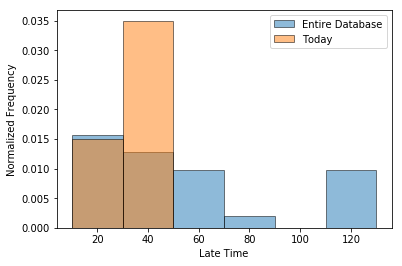

,Month,Day,Year,Bus Number,School,To/From,Time,Unit,Data Taken Month,Data Taken Day,Data Taken Year,Data Taken Hour,Data Taken Minute
57,January,7,2019,263,Salmon Bay,to,75,minutes,1,7,2019,7,20
58,January,7,2019,364,Nathan Hale,to,30,minutes,1,7,2019,7,20
59,January,7,2019,365,Nathan Hale,to,75,minutes,1,7,2019,7,20
60,January,7,2019,607,Lawton,to,120,minutes,1,7,2019,7,20
61,January,7,2019,415,World,to,60,minutes,1,7,2019,7,20
62,January,7,2019,72,Hawthorne,to,120,minutes,1,7,2019,7,20
63,January,7,2019,254,Orca,to,60,minutes,1,7,2019,7,20
64,January,7,2019,224,WSES,to,120,minutes,1,7,2019,7,20
65,January,7,2019,648,Thurgood Marshall,to,60,minutes,1,7,2019,7,20
66,January,7,2019,185,Stevens,to,120,minutes,1,7,2019,7,20


In [23]:
all_late_buses = entire_database_fn(late_bus_df, "to")
todays_late_buses = today_late_buses_fn(late_bus_df, "to")

#histogram
binwidth = 20
transparency = 0.5

all_data = all_late_buses.get("Time")
plt.hist(all_data, bins = np.arange(min(all_data), max(all_data) +binwidth, binwidth), 
         alpha = transparency, density = 1, weights = weights_all, linewidth=1, edgecolor = 'k', label = 'Entire Database')

today_data = todays_late_buses.get("Time")
plt.hist(today_data, bins = np.arange(min(all_data), max(all_data) +binwidth, binwidth),  
         alpha = transparency, density = 1, weights = weights_today, linewidth=1, edgecolor = 'k', label = 'Today',)

plt.xlabel("Late Time")
plt.ylabel("Normalized Frequency")
plt.legend(loc='upper right')
plt.show()

#show first 10 rows of df
all_late_buses[0:10]

# Map of schools with late buses.

In [7]:
#---data to visualize----
#visualize = 'Late Time' # visualize the total number of minutes of late buses per school
visualize = 'count' # visualize the total number of late buses per school

#----get df with schools that have late buses-----
#df_of_interest_fn = today_late_buses_fn
df_of_interest_fn = entire_database_fn

#------------------------------
#from arcgis.geocoding import geocoding
my_gis = GIS()
seattle = my_gis.map("Seattle, WA")

# ----map all schools---
for index, school in school_df.iterrows():
    if school['latitude'] != 0:
        [circle_location, pop_up_description, circle_format] = map_all_schools_fn(school)
        seattle.draw(circle_location, pop_up_description, circle_format)
    # some schools don't have an address in the table
    #except:
    #    pass  

late_schools_df = get_important_df_fn(df_of_interest_fn, late_bus_df, school_df, "to")
print("Number of schools with late buses: ", late_schools_df.shape[0])

# map schools with late buses, total late time
for index, school in late_schools_df.iterrows():
    color_code = color_code_fn(school['Type'])
    d = circle_diameter_fn(max_diameter = 10, amount = school[visualize], 
                           array_of_amounts = late_schools_df[visualize])
    [circle_location, pop_up_description, circle_format] = map_late_schools_fn(school, d, color_code, visualize)
    seattle.draw(circle_location, pop_up_description, circle_format)

seattle


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of schools with late buses:  29


MapView(layout=Layout(height='400px', width='100%'))